In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm
import math
import random

# Funções

In [56]:
def bootstrap_mean(data, n):
    values = []
    for i in range(n):
        df = data.sample(n = len(data), replace= True)
        values.append(np.mean(df))
    return values

def percentile(data, init, final):
    inferior = np.percentile(data, q = init)
    superior = np.percentile(data, q = final)
    return [inferior, superior]

def calcula_ic(df):
    n = len(df)
    sample_mean = np.mean(df)
    sample_variance = np.var(df, ddof = 1)
    inferior = sample_mean - 1.96*np.sqrt(sample_variance/n)
    superior = sample_mean + 1.96*np.sqrt(sample_variance/n)
    return [inferior, superior]

def teste_ab(df_hyp_menor, df_hyp_maior):
    x, y = calcula_ic(df_hyp_menor)
    x2, y2 = calcula_ic(df_hyp_maior)
    if x2 > y:
        return True
    else:
        return False

In [160]:
df = pd.read_parquet("datasets/dataset_pos_limpeza.parquet")
df.head()

,cod_mun,nom_mun,sig_uf,regiao,tx_aprov_ef_1,saeb_mat_ef_1,saeb_port_ef_1,ideb_ef_1,tx_aprov_ef_2,saeb_mat_ef_2,...,type,num_operadoras,0_a_2_mbs,2.5_a_5_mbs,6_a_10_mbs,11_a_15_mbs,15_a_25_mbs,acima_25_mbs,0_a_10_mbs,acima_10_mbs
0,1100015,ALTA FLORESTA D'OESTE,RO,NORTE,92.4,226.44,204.70,5.7,95.3,270.02,...,broadband,3.0,0.001066,0.000000,0.000000,0.000000,0.000000,0.000902,0.001066,0.000902
1,1100023,ARIQUEMES,RO,NORTE,88.7,214.18,199.92,5.2,93.7,266.09,...,broadband,7.0,0.000598,0.001040,0.000952,0.000133,0.000697,0.001793,0.002590,0.002623
2,1100023,ARIQUEMES,RO,NORTE,88.7,214.18,199.92,5.2,93.7,266.09,...,mobile,1.0,0.000000,0.000155,0.000266,0.000354,0.000000,0.000000,0.000421,0.000354
3,1100049,CACOAL,RO,NORTE,98.0,223.45,209.48,5.8,98.3,267.51,...,broadband,5.0,0.000738,0.000916,0.000000,0.000000,0.000535,0.005396,0.001654,0.005931
4,1100049,CACOAL,RO,NORTE,98.0,223.45,209.48,5.8,98.3,267.51,...,mobile,3.0,0.000204,0.000407,0.000000,0.000407,0.000000,0.000000,0.000611,0.000407


# 1. Testes de Hipótese

### 1.1 Diferenças entre as taxas de aprovação dos estados

In [4]:
df_sul = df[df['regiao'] == 'SUL']
df_sudeste = df[df['regiao'] == 'SUDESTE']
df_centro_oeste = df[df['regiao'] == 'CENTRO-OESTE']
df_nordeste = df[df['regiao'] == 'NORDESTE']
df_norte = df[df['regiao'] == 'NORTE']

In [8]:
def comparacao_tx_aprov (df, etapa_ensino, regiao_1, regiao_2):
    assert etapa_ensino == "tx_aprov_ef_1" or etapa_ensino == "tx_aprov_ef_2" or etapa_ensino == "tx_aprov_em"
    
    data_1 = df[df['regiao'] == regiao_1.upper()][etapa_ensino]
    data_2 = df[df['regiao'] == regiao_2.upper() ][etapa_ensino]
    if etapa_ensino == "tx_aprov_ef_1":
        x = "nos anos iniciais do ensino fundamental"
    elif etapa_ensino == "tx_aprov_ef_2":
        x = "nos anos finais do ensino fundamental"
    else:
        x = "no ensino médio"
    print(f"Existe evidência de que a taxa de aprovação {x} no {regiao_2} é maior do que no {regiao_1}?")
    if teste_ab(data_1, data_2) == True:
        print("Sim")
    else:
        print("Não")
    print(f"Intervalos de confiança:\n {regiao_1}", calcula_ic(data_1), f"{regiao_2}", calcula_ic(data_2), "\n")

In [9]:
comparacao_tx_aprov(df, "tx_aprov_em", "nordeste", "sudeste")
comparacao_tx_aprov(df, "tx_aprov_em", "norte", "sudeste")
comparacao_tx_aprov(df, "tx_aprov_em", "centro-oeste", "sudeste")
comparacao_tx_aprov(df, "tx_aprov_em", "sul", "sudeste")

Existe evidência de que a taxa de aprovação no ensino médio no sudeste é maior do que no nordeste?
Sim
Intervalos de confiança:
 nordeste [84.37589254261596, 85.34355190182839] sudeste [88.38377258303939, 89.09042096534785] 

Existe evidência de que a taxa de aprovação no ensino médio no sudeste é maior do que no norte?
Sim
Intervalos de confiança:
 norte [81.25064751829753, 83.04682540589017] sudeste [88.38377258303939, 89.09042096534785] 

Existe evidência de que a taxa de aprovação no ensino médio no sudeste é maior do que no centro-oeste?
Sim
Intervalos de confiança:
 centro-oeste [83.47058613060253, 85.58309557961132] sudeste [88.38377258303939, 89.09042096534785] 

Existe evidência de que a taxa de aprovação no ensino médio no sudeste é maior do que no sul?
Sim
Intervalos de confiança:
 sul [83.8299580596733, 84.72316969363051] sudeste [88.38377258303939, 89.09042096534785] 



Assim, temos evidência estatística de que a taxa de aprovação no ensino médio é maior no sudeste do que nas outras regiões. Será que o padrão se repete para as taxas de aprovação no ensino fundamental?

In [10]:
comparacao_tx_aprov(df, "tx_aprov_ef_1", "nordeste", "sudeste")
comparacao_tx_aprov(df, "tx_aprov_ef_1", "norte", "sudeste")
comparacao_tx_aprov(df, "tx_aprov_ef_1", "centro-oeste", "sudeste")
comparacao_tx_aprov(df, "tx_aprov_ef_1", "sul", "sudeste")

Existe evidência de que a taxa de aprovação nos anos iniciais do ensino fundamental no sudeste é maior do que no nordeste?
Sim
Intervalos de confiança:
 nordeste [90.10349360177604, 90.81179535213771] sudeste [97.25856433579618, 97.59221466016437] 

Existe evidência de que a taxa de aprovação nos anos iniciais do ensino fundamental no sudeste é maior do que no norte?
Sim
Intervalos de confiança:
 norte [88.91512015834472, 90.62064626501292] sudeste [97.25856433579618, 97.59221466016437] 

Existe evidência de que a taxa de aprovação nos anos iniciais do ensino fundamental no sudeste é maior do que no centro-oeste?
Sim
Intervalos de confiança:
 centro-oeste [96.34818904397757, 96.98435812583394] sudeste [97.25856433579618, 97.59221466016437] 

Existe evidência de que a taxa de aprovação nos anos iniciais do ensino fundamental no sudeste é maior do que no sul?
Sim
Intervalos de confiança:
 sul [95.21868220230202, 95.72711053463361] sudeste [97.25856433579618, 97.59221466016437] 



Ou seja, o resultado se repete para os anos iniciais do ensino fundamental! 

In [11]:
comparacao_tx_aprov(df, "tx_aprov_ef_2", "nordeste", "sudeste")
comparacao_tx_aprov(df, "tx_aprov_ef_2", "norte", "sudeste")
comparacao_tx_aprov(df, "tx_aprov_ef_2", "centro-oeste", "sudeste")
comparacao_tx_aprov(df, "tx_aprov_ef_2", "sul", "sudeste")

Existe evidência de que a taxa de aprovação nos anos finais do ensino fundamental no sudeste é maior do que no nordeste?
Sim
Intervalos de confiança:
 nordeste [90.73241279371781, 91.45294591784919] sudeste [92.37974924299355, 92.89997425930984] 

Existe evidência de que a taxa de aprovação nos anos finais do ensino fundamental no sudeste é maior do que no norte?
Sim
Intervalos de confiança:
 norte [89.1339487617496, 90.49059997471238] sudeste [92.37974924299355, 92.89997425930984] 

Existe evidência de que a taxa de aprovação nos anos finais do ensino fundamental no sudeste é maior do que no centro-oeste?
Não
Intervalos de confiança:
 centro-oeste [92.37292559028768, 93.48716830642607] sudeste [92.37974924299355, 92.89997425930984] 

Existe evidência de que a taxa de aprovação nos anos finais do ensino fundamental no sudeste é maior do que no sul?
Sim
Intervalos de confiança:
 sul [91.58414348282209, 92.1725466580232] sudeste [92.37974924299355, 92.89997425930984] 



Curiosamente, para os anos finais do ensino fundamental não há evidência de que o ensino no sudeste seja melhor do que o do 
centro-oeste, embora ainda seja melhor do que o das outras regiões.

### 1.2 Diferenças entre as taxas de aprovação de municípios pobres e ricos

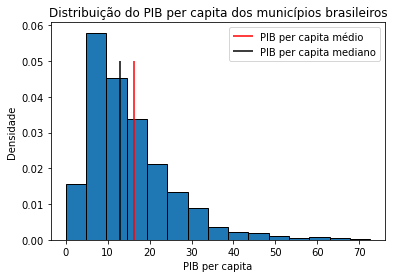

In [59]:
municipios_outliers = np.percentile(df['pib_per_capita'], 99)
plt.hist(df['pib_per_capita'], ec = 'black', density = True, bins = 15, range = (0, municipios_outliers))
plt.title('Distribuição do PIB per capita dos municípios brasileiros')
plt.vlines(np.mean(df['pib_per_capita']), ymin = 0, ymax = 0.05, color = 'red', label = 'PIB per capita médio')
plt.vlines(np.median(df['pib_per_capita']), ymin = 0, ymax = 0.05, color = 'black', label = 'PIB per capita mediano')
plt.xlabel('PIB per capita')
plt.ylabel('Densidade')
plt.legend()
plt.show()

A taxa de aprovação escolar de municípios com PIB per capita acima da média é maior do que a taxa de aprovação de municípios com PIB per capita abaixo da média? Desta vez vamos montar os intervalos de confiança usando bootstrap!

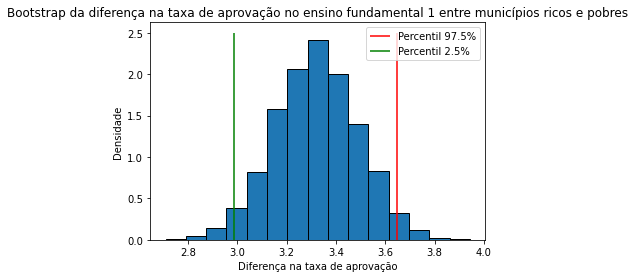

In [103]:
df_renda = df[['pib_per_capita', 'tx_aprov_ef_1']].dropna(axis = 0, how = 'any')
median_income = np.median(df_renda['pib_per_capita'])
df_rico = df_renda[df_renda['pib_per_capita'] > median_income].reset_index()['tx_aprov_ef_1']
df_pobre = df_renda[df_renda['pib_per_capita'] <= median_income].reset_index()['tx_aprov_ef_1'][0:-1]
df_diferenca = df_rico - df_pobre
bootstrap_diferenca = bootstrap_mean(df_diferenca, 10000)
ic_lower, ic_upper = percentile(bootstrap_diferenca, 2.5, 97.5)
plt.hist(bootstrap_diferenca, ec = 'black', density = True, bins = 15)
plt.title('Bootstrap da diferença na taxa de aprovação no ensino fundamental 1 entre municípios ricos e pobres')
plt.vlines(ic_upper, color = 'red', ymin = 0, ymax = 2.5, label = 'Percentil 97.5%')
plt.vlines(ic_lower, color = 'green', ymin = 0, ymax = 2.5, label = 'Percentil 2.5%')
plt.xlabel('Diferença na taxa de aprovação')
plt.ylabel('Densidade')
plt.legend()
plt.show()

Como podemos observar, o intervalo de confiança para a diferença entre municípios ricos e pobres é (2.99, 3.64), intervalo que não contém o zero. Logo podemos concluir que a taxa de aprovação no ensino fundamental 1 é significativamente maior para municípios ricos do que pobres. Será que o mesmo resultado se aplica para o ensino fundamental 2 e para o ensino médio?

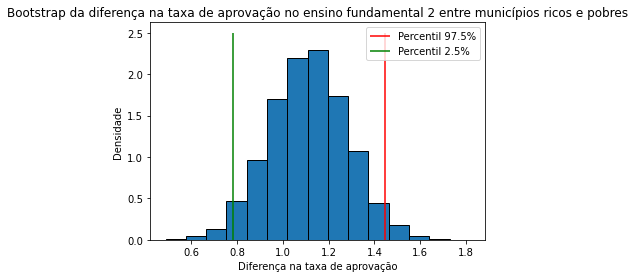

In [104]:
df_renda = df[['pib_per_capita', 'tx_aprov_ef_2']].dropna(axis = 0, how = 'any')
median_income = np.median(df_renda['pib_per_capita'])
df_rico = df_renda[df_renda['pib_per_capita'] > median_income].reset_index()['tx_aprov_ef_2']
df_pobre = df_renda[df_renda['pib_per_capita'] <= median_income].reset_index()['tx_aprov_ef_2'][0:-1]
df_diferenca = df_rico - df_pobre
bootstrap_diferenca = bootstrap_mean(df_diferenca, 10000)
ic_lower, ic_upper = percentile(bootstrap_diferenca, 2.5, 97.5)
plt.hist(bootstrap_diferenca, ec = 'black', density = True, bins = 15)
plt.title('Bootstrap da diferença na taxa de aprovação no ensino fundamental 2 entre municípios ricos e pobres')
plt.vlines(ic_upper, color = 'red', ymin = 0, ymax = 2.5, label = 'Percentil 97.5%')
plt.vlines(ic_lower, color = 'green', ymin = 0, ymax = 2.5, label = 'Percentil 2.5%')
plt.xlabel('Diferença na taxa de aprovação')
plt.ylabel('Densidade')
plt.legend()
plt.show()


Novamente o intervalo de confiança não contém o zero, embora desta feita a diferença entre as taxas de aprovação seja menor.

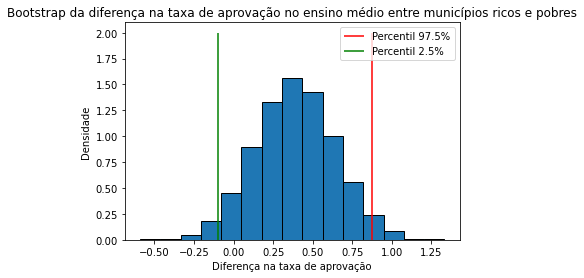

In [105]:
df_renda = df[['pib_per_capita', 'tx_aprov_em']].dropna(axis = 0, how = 'any')
median_income = np.median(df_renda['pib_per_capita'])
df_rico = df_renda[df_renda['pib_per_capita'] > median_income].reset_index()['tx_aprov_em']
df_pobre = df_renda[df_renda['pib_per_capita'] <= median_income].reset_index()['tx_aprov_em'][0:-1]
df_diferenca = df_rico - df_pobre
bootstrap_diferenca = bootstrap_mean(df_diferenca, 10000)
ic_lower, ic_upper = percentile(bootstrap_diferenca, 2.5, 97.5)
plt.hist(bootstrap_diferenca, ec = 'black', density = True, bins = 15)
plt.title('Bootstrap da diferença na taxa de aprovação no ensino médio entre municípios ricos e pobres')
plt.vlines(ic_upper, color = 'red', ymin = 0, ymax = 2, label = 'Percentil 97.5%')
plt.vlines(ic_lower, color = 'green', ymin = 0, ymax = 2, label = 'Percentil 2.5%')
plt.xlabel('Diferença na taxa de aprovação')
plt.ylabel('Densidade')
plt.legend()
plt.show()

O intervalo de confiança para a diferença na taxa de aprovação no ensino medio inclui o zero. Logo, não podemos concluir que haja diferença significativa nas taxas de aprovação no ensino médio entre municípios ricos e pobres.

## 1.3 Diferenças entre as taxas de aprovação dos municípios com menor acesso a internet e maior acesso a internet

Usaremos, nesse caso, a melhor faixa de velocidade de acesso a internet, de acima de 10 mb/s

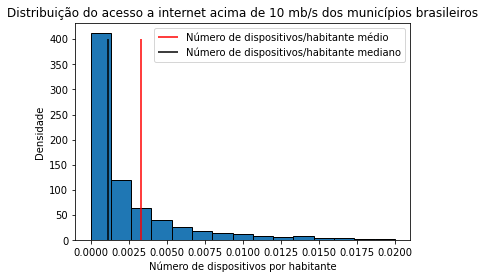

In [181]:
municipios_outliers = np.percentile(df['acima_10_mbs'], 97.5)
plt.hist(df['acima_10_mbs'], ec = 'black', density = True, bins = 15, range = (0, municipios_outliers))
plt.title('Distribuição do acesso a internet acima de 10 mb/s dos municípios brasileiros')
plt.vlines(np.mean(df['acima_10_mbs']), ymin = 0, ymax = 400, color = 'red', label = 'Número de dispositivos/habitante médio')
plt.vlines(np.median(df['acima_10_mbs']), ymin = 0, ymax = 400, color = 'black', 
           label = 'Número de dispositivos/habitante mediano')
plt.xlabel('Número de dispositivos por habitante')
plt.ylabel('Densidade')
plt.legend()
plt.show()

Primeiro veremos a diferença para a taxa de aprovação no ensino fundamental 1

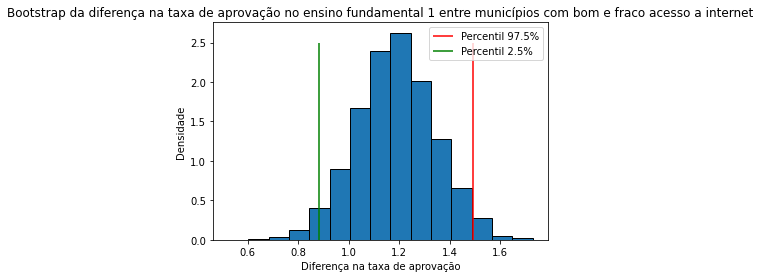

In [183]:
df_internet = df[['acima_10_mbs', 'tx_aprov_ef_1']].dropna(axis = 0, how = 'any')
median_internet = np.median(df_internet['acima_10_mbs'])
df_acesso_alto = df_internet[df_internet['acima_10_mbs'] > median_internet].reset_index()['tx_aprov_ef_1']
df_acesso_baixo = df_internet[df_internet['acima_10_mbs'] <= median_internet].reset_index()['tx_aprov_ef_1'][0:-1]
df_diferenca = df_acesso_alto - df_acesso_baixo
bootstrap_diferenca = bootstrap_mean(df_diferenca, 10000)
ic_lower, ic_upper = percentile(bootstrap_diferenca, 2.5, 97.5)
plt.hist(bootstrap_diferenca, ec = 'black', density = True, bins = 15)
plt.title('Bootstrap da diferença na taxa de aprovação no ensino fundamental 1 entre municípios com bom e fraco acesso a internet')
plt.vlines(ic_upper, color = 'red', ymin = 0, ymax = 2.5, label = 'Percentil 97.5%')
plt.vlines(ic_lower, color = 'green', ymin = 0, ymax = 2.5, label = 'Percentil 2.5%')
plt.xlabel('Diferença na taxa de aprovação')
plt.ylabel('Densidade')
plt.legend()
plt.show()

Como o intervalo de confiança gerado por bootstrap não inclui o zero, podemos concluir que o melhor acesso à internet nas faixas mais altas está positivamente correlacionado com a taxa de aprovação no ensino fundamental 1

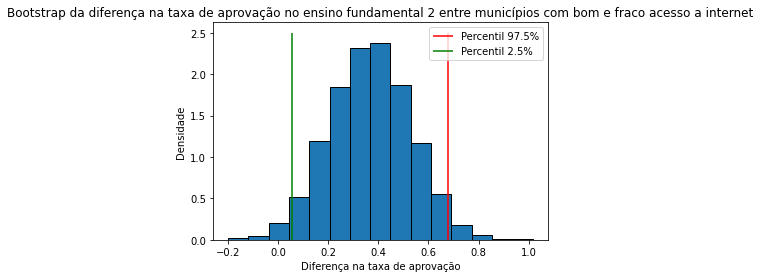

In [184]:
df_internet = df[['acima_10_mbs', 'tx_aprov_ef_2']].dropna(axis = 0, how = 'any')
median_internet = np.median(df_internet['acima_10_mbs'])
df_acesso_alto = df_internet[df_internet['acima_10_mbs'] > median_internet].reset_index()['tx_aprov_ef_2']
df_acesso_baixo = df_internet[df_internet['acima_10_mbs'] <= median_internet].reset_index()['tx_aprov_ef_2'][0:-1]
df_diferenca = df_acesso_alto - df_acesso_baixo
bootstrap_diferenca = bootstrap_mean(df_diferenca, 10000)
ic_lower, ic_upper = percentile(bootstrap_diferenca, 2.5, 97.5)
plt.hist(bootstrap_diferenca, ec = 'black', density = True, bins = 15)
plt.title('Bootstrap da diferença na taxa de aprovação no ensino fundamental 2 entre municípios com bom e fraco acesso a internet')
plt.vlines(ic_upper, color = 'red', ymin = 0, ymax = 2.5, label = 'Percentil 97.5%')
plt.vlines(ic_lower, color = 'green', ymin = 0, ymax = 2.5, label = 'Percentil 2.5%')
plt.xlabel('Diferença na taxa de aprovação')
plt.ylabel('Densidade')
plt.legend()
plt.show()

Para o ensino fundamental 2, o intervalo ainda é positivo e não inclui o zero, mas a diferença é menor.

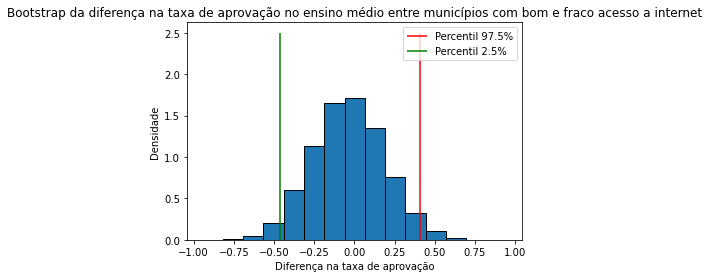

In [185]:
df_internet = df[['acima_10_mbs', 'tx_aprov_em']].dropna(axis = 0, how = 'any')
median_internet = np.median(df_internet['acima_10_mbs'])
df_acesso_alto = df_internet[df_internet['acima_10_mbs'] > median_internet].reset_index()['tx_aprov_em']
df_acesso_baixo = df_internet[df_internet['acima_10_mbs'] <= median_internet].reset_index()['tx_aprov_em'][0:-1]
df_diferenca = df_acesso_alto - df_acesso_baixo
bootstrap_diferenca = bootstrap_mean(df_diferenca, 10000)
ic_lower, ic_upper = percentile(bootstrap_diferenca, 2.5, 97.5)
plt.hist(bootstrap_diferenca, ec = 'black', density = True, bins = 15)
plt.title('Bootstrap da diferença na taxa de aprovação no ensino médio entre municípios com bom e fraco acesso a internet')
plt.vlines(ic_upper, color = 'red', ymin = 0, ymax = 2.5, label = 'Percentil 97.5%')
plt.vlines(ic_lower, color = 'green', ymin = 0, ymax = 2.5, label = 'Percentil 2.5%')
plt.xlabel('Diferença na taxa de aprovação')
plt.ylabel('Densidade')
plt.legend()
plt.show()

O intervalo de confiança inclui o zero. Logo concluímos que não há evidência estatística de uma diferença significante entre a taxa de aprovação no ensino médio para municípios com mais e menos acesso às faixas de internet melhores.

# 2. Regressões Lineares

### 2.1 Regressões Simples



**Ensino Fundamental 1**

Como a quantidade de dispositivos de 0 a 2 mb/s por habitante está correlacionada com a taxa de aprovação nos anos iniciais do ensino fundamental?

In [12]:
X = df['0_a_2_mbs']
Y = df['tx_aprov_ef_1']
X = sm.add_constant(X)
model_1 = sm.OLS(Y, X, missing = 'drop').fit()
results = model_1.summary()
print(results)

                            OLS Regression Results                            
Dep. Variable:          tx_aprov_ef_1   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     13.80
Date:                Thu, 04 Mar 2021   Prob (F-statistic):           0.000205
Time:                        07:41:23   Log-Likelihood:                -15705.
No. Observations:                4927   AIC:                         3.141e+04
Df Residuals:                    4925   BIC:                         3.143e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         94.3538      0.099    949.693      0.0

Na primeira regressão observamos um valor positivo e significativo (p-valor = 0 < 0.05), o que indica que um maior número de dispositivos de internet por habitante está correlacionado com melhores taxas de aprovação no ensino fundamental 1. O R2 da regressão, entretanto, é baixo, de apenas 0,003. Abaixo plotamos esta reta no gráfico, o que indica uma pequena inclinação positiva.

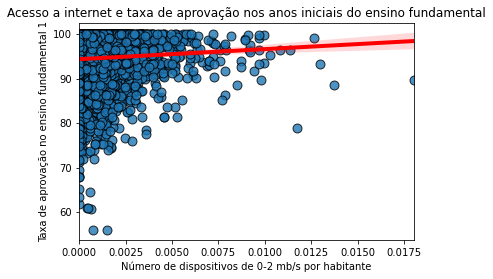

In [13]:
sns.regplot(x='0_a_2_mbs', y='tx_aprov_ef_1', data=df, n_boot=10000,
            line_kws={'color':'red', 'lw':4},
           scatter_kws={'edgecolor':'k', 's':80, 'alpha':0.8})
plt.title('Acesso a internet e taxa de aprovação nos anos iniciais do ensino fundamental')
plt.ylabel('Taxa de aprovação no ensino fundamental 1')
plt.xlabel('Número de dispositivos de 0-2 mb/s por habitante')
plt.show()

Para ver se o modelo está bem ajustado, olhemos para a distribuição de seus resíduos.

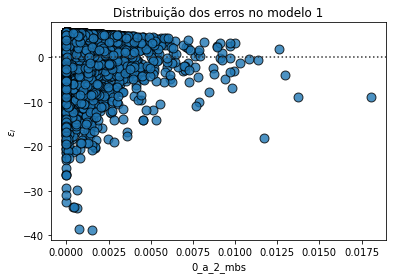

In [14]:
sns.residplot(x='0_a_2_mbs', y='tx_aprov_ef_1', data=df,
              line_kws={'color':'red', 'lw':4},
              scatter_kws={'edgecolor':'k', 's':80, 'alpha':0.8},
              dropna = True)
plt.ylabel(r'$\epsilon_i$')
plt.xlabel('0_a_2_mbs')
plt.title('Distribuição dos erros no modelo 1')
plt.show()

Os resíduos estão (longe) de se assemelhar a uma distribuição normal, o que indica que um modelo de regressão linear simples 
não é adequado para explicar a taxa de aprovação.

**Ensino Fundamental 2**

Olhemos agora como o acesso a dispositivos de internet afeta a aprovação nos anos finais do ensino fundamental.

In [15]:
X = df['0_a_2_mbs']
Y = df['tx_aprov_ef_2']
X = sm.add_constant(X)
model_2 = sm.OLS(Y, X, missing = 'drop').fit()
results = model_2.summary()
print(results)

                            OLS Regression Results                            
Dep. Variable:          tx_aprov_ef_2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.118
Date:                Thu, 04 Mar 2021   Prob (F-statistic):              0.146
Time:                        07:41:35   Log-Likelihood:                -15788.
No. Observations:                4941   AIC:                         3.158e+04
Df Residuals:                    4939   BIC:                         3.159e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         91.9823      0.100    919.839      0.0

Agora obtemos um coeficiente negativo, embora não significativo (p-valor = 0.146 > 0.05). Isto é, não existe evidência, 
neste modelo, de que o acesso a dispositivos de internet afete a taxa de aprovação nos anos finais do ensino fundamental. O
R2, neste caso, é aproximadamente zero, o que indica novamente que o modelo univariado não é capaz de explicar a distribuição
da variável resposta. A inclinação da reta abaixo mostra um efeito praticamente nulo.

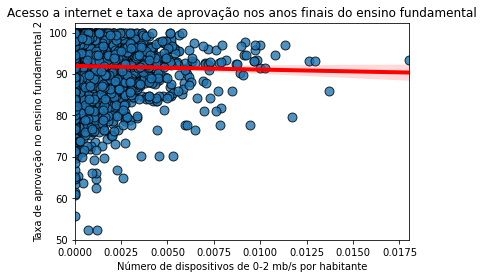

In [16]:
sns.regplot(x='0_a_2_mbs', y='tx_aprov_ef_2', data=df, n_boot=10000,
            line_kws={'color':'red', 'lw':4},
            scatter_kws={'edgecolor':'k', 's':80, 'alpha':0.8})
plt.title('Acesso a internet e taxa de aprovação nos anos finais do ensino fundamental')
plt.ylabel('Taxa de aprovação no ensino fundamental 2')
plt.xlabel('Número de dispositivos de 0-2 mb/s por habitante')
plt.show()

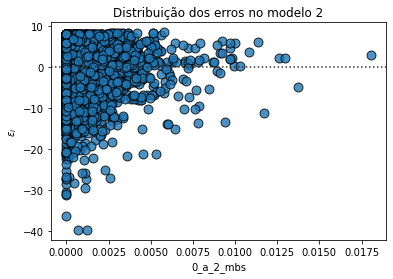

In [17]:
sns.residplot(x='0_a_2_mbs', y='tx_aprov_ef_2', data=df,
              line_kws={'color':'red', 'lw':4},
              scatter_kws={'edgecolor':'k', 's':80, 'alpha':0.8},
              dropna = True)
plt.ylabel(r'$\epsilon_i$')
plt.xlabel('0_a_2_mbs')
plt.title('Distribuição dos erros no modelo 2')
plt.show()

Observamos que também os resíduos desse modelo não parecem ser normalmente distribuídos.

**Ensino Médio**


Olhemos agora como o acesso a dispositivos de internet está correlacionado com a taxa de aprovação no ensino médio.

In [18]:
X = df['0_a_2_mbs']
Y = df['tx_aprov_em']
X = sm.add_constant(X)
model_3 = sm.OLS(Y, X, missing = 'drop').fit()
results = model_3.summary()
print(results)

                            OLS Regression Results                            
Dep. Variable:            tx_aprov_em   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     15.37
Date:                Thu, 04 Mar 2021   Prob (F-statistic):           8.96e-05
Time:                        07:41:47   Log-Likelihood:                -17654.
No. Observations:                4937   AIC:                         3.531e+04
Df Residuals:                    4935   BIC:                         3.533e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         86.2190      0.146    589.213      0.0

Podemos ver que o coeficiente é negativo e significativo (p-valor = 0 < 0.005), o que indica uma correlação negativa entre
o acesso a dispositivos de internet e a taxa de aprovação no ensino médio. Abaixo plotamos a reta com esta inclinação
no gráfico de distribuição da variável resposta.

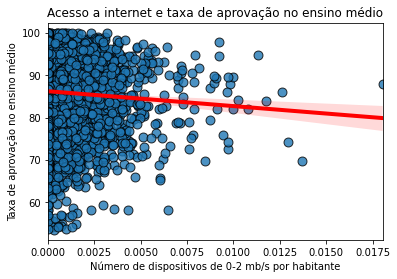

In [19]:
sns.regplot(x='0_a_2_mbs', y='tx_aprov_em', data=df, n_boot=10000,
            line_kws={'color':'red', 'lw':4},
            scatter_kws={'edgecolor':'k', 's':80, 'alpha':0.8})
plt.title('Acesso a internet e taxa de aprovação no ensino médio')
plt.ylabel('Taxa de aprovação no ensino médio')
plt.xlabel('Número de dispositivos de 0-2 mb/s por habitante')
plt.show()

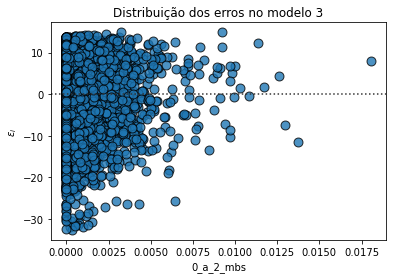

In [20]:
sns.residplot(x='0_a_2_mbs', y='tx_aprov_em', data=df,
              line_kws={'color':'red', 'lw':4},
              scatter_kws={'edgecolor':'k', 's':80, 'alpha':0.8},
              dropna = True)
plt.ylabel(r'$\epsilon_i$')
plt.xlabel('0_a_2_mbs')
plt.title('Distribuição dos erros no modelo 3')
plt.show()

Podemos ver que os resíduos deste modelo ficaram melhor distribuídos do que os resíduos dos modelos anteriores, embora ainda não se assemelhem a uma distribuição normal.

### 2.2 Regressões Multivariadas

Agora iremos realizar as regressões incluindo um vetor de variáveis de controle, de modo a controlar pela presença de fatores
que confundam a relação direta entre os índices educacionais e o número de dispositivos de internet. Primeiro verificamos a 
correlação entre as diferentes variáveis de nossa base:


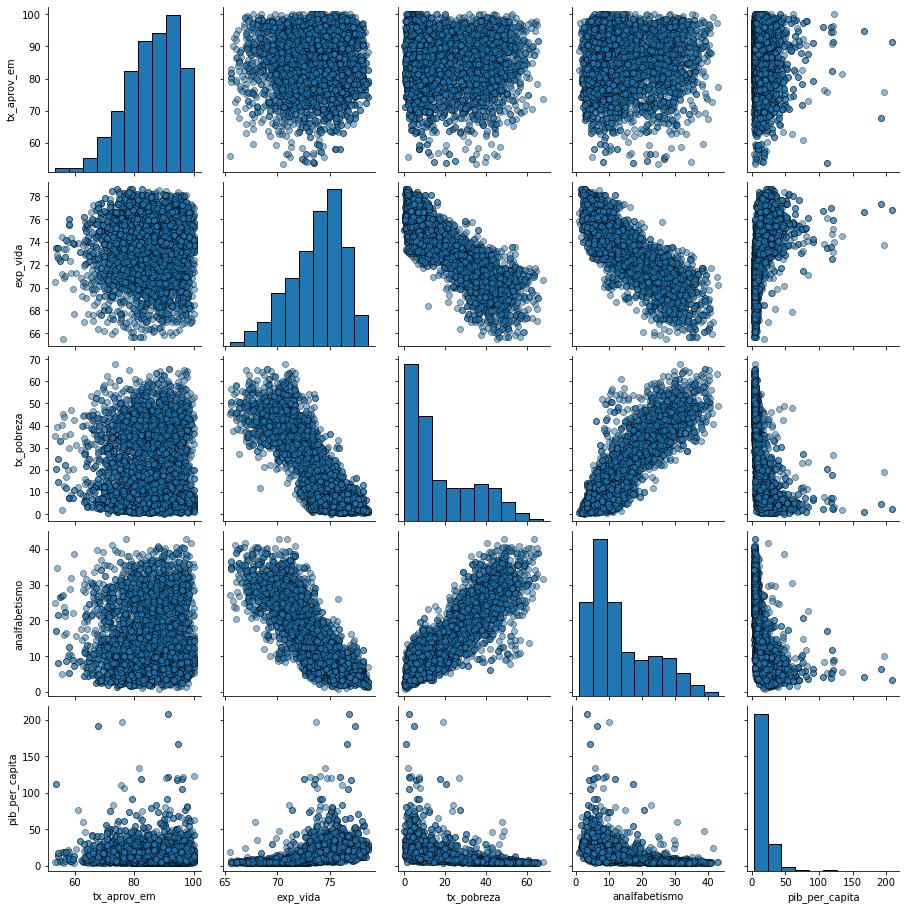

In [21]:
variables_1 = ['tx_aprov_em', 'exp_vida', 'tx_pobreza','analfabetismo', 'pib_per_capita']
sns.pairplot(df[variables_1], diag_kws={'edgecolor':'k'}, plot_kws={'alpha':0.5, 'edgecolor':'k'})
plt.show()

[]

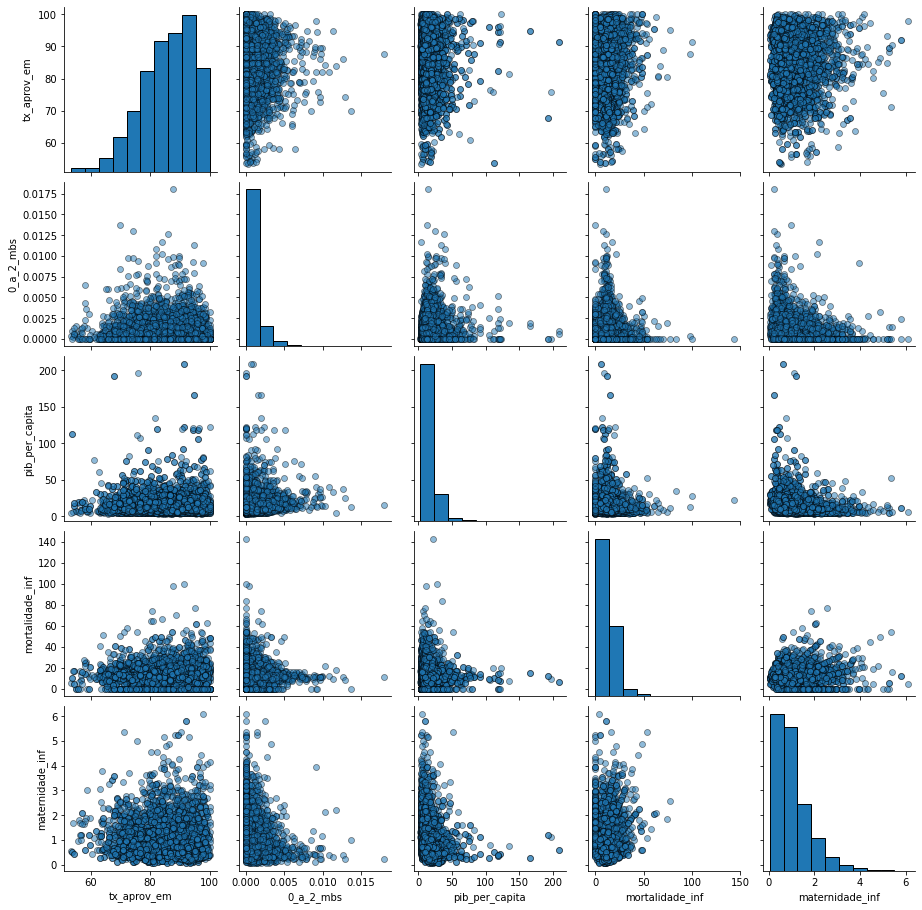

In [22]:
variables_2 = ['tx_aprov_em','0_a_2_mbs', 'pib_per_capita', 'mortalidade_inf', 'maternidade_inf']
sns.pairplot(df[variables_2], diag_kws={'edgecolor':'k'}, plot_kws={'alpha':0.5, 'edgecolor':'k'})
plt.plot()

Para esta etapa, iremos dividir nossos dados em três partes: a parte de treino (80% dos dados), a parte de checagem do modelo (10% dos dados) e a parte
para apresentação final dos resultados (10% dos dados). Iremos sortear essa distribuição de maneira aleatória. Desta forma, a
amostra de treino contém 3958 observações, a amostra de validagem contém 494 observações e a amostra de apresentação contém
495 observações.

In [161]:
from sklearn.utils import shuffle
random.seed(3467)
df2 = shuffle(df, random_state = 3647).reset_index(drop = True)

training_sample_number = round(df2.shape[0]*0.8)
validation_sample_number = round(df2.shape[0]*0.9)
presentation_sample_number = round(df2.shape[0]*1)

df_train = df2.loc[0:training_sample_number].reset_index(drop = True)
df_validation = df2.loc[training_sample_number:validation_sample_number].reset_index(drop = True)
df_presentation = df2.loc[validation_sample_number:presentation_sample_number].reset_index(drop = True)

display(df_train)

,cod_mun,nom_mun,sig_uf,regiao,tx_aprov_ef_1,saeb_mat_ef_1,saeb_port_ef_1,ideb_ef_1,tx_aprov_ef_2,saeb_mat_ef_2,...,type,num_operadoras,0_a_2_mbs,2.5_a_5_mbs,6_a_10_mbs,11_a_15_mbs,15_a_25_mbs,acima_25_mbs,0_a_10_mbs,acima_10_mbs
0,4200309,AGRONOMICA,SC,SUL,98.6,204.77,207.81,5.5,84.5,259.64,...,broadband,4.0,0.000000,0.000408,0.000000,0.000000,0.000816,0.004078,0.000408,0.004894
1,2800605,BARRA DOS COQUEIROS,SE,NORDESTE,81.4,186.45,176.14,4.1,70.3,244.28,...,broadband,10.0,0.004564,0.000000,0.000080,0.002322,0.004244,0.003684,0.004644,0.010250
2,3502903,ARACOIABA DA SERRA,SP,SUDESTE,100.0,239.41,224.53,6.5,98.8,261.07,...,mobile,2.0,0.000806,0.000073,0.000000,0.000440,0.000000,0.000000,0.000879,0.000440
3,4316477,SALVADOR DAS MISSOES,RS,SUL,95.7,243.69,226.79,6.7,86.2,283.77,...,broadband,3.0,0.000000,0.000000,0.000000,0.000000,0.000749,0.001499,0.000000,0.002248
4,3165537,SARZEDO,MG,SUDESTE,98.8,241.82,227.65,6.6,88.4,244.25,...,broadband,4.0,0.000000,0.000077,0.000000,0.000232,0.000465,0.004184,0.000077,0.004881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954,4323804,XANGRI-LA,RS,SUL,81.3,224.72,208.12,5.4,79.8,267.43,...,broadband,7.0,0.003378,0.000000,0.003458,0.002413,0.005549,0.015763,0.006836,0.023725
3955,2408003,MOSSORO,RN,NORDESTE,91.5,220.68,210.88,5.6,89.1,250.59,...,broadband,8.0,0.001005,0.000435,0.000539,0.000062,0.000789,0.002305,0.001978,0.003156
3956,2505279,CURRAL DE CIMA,PB,NORDESTE,93.2,209.65,206.39,5.5,94.1,232.68,...,broadband,3.0,0.000000,0.000384,0.000192,0.000000,0.000384,0.000000,0.000576,0.000384
3957,3527603,LUIS ANTONIO,SP,SUDESTE,96.6,243.06,217.46,6.2,91.9,272.77,...,broadband,2.0,0.000000,0.000000,0.000000,0.000709,0.000000,0.000886,0.000000,0.001595


Primeiro geramos algumas variáveis de interesse na base: 

* o número de dispositivos de acesso a internet ao quadrado (para modelar uma relação não linear)
* uma variável interativa entre o número de dispositivos de acesso a internet e o número de operadoras de telefonia,
    como forma de capturar um efeito de competição
* variáveis dummies para as regiões brasileiras
    
(Note que renomeamos df_train como df)

In [162]:
df_train['0_a_2_mbs_squared'] = df_train['0_a_2_mbs']*df_train['0_a_2_mbs']
df_train['0_a_2_mbs_*_num_operadoras'] = df_train['0_a_2_mbs']*df_train['num_operadoras']

regiao_dummy = pd.get_dummies(df_train['regiao'])
regiao_dummy
df_train['Centro-Oeste'] = regiao_dummy['CENTRO-OESTE']
df_train['Nordeste'] = regiao_dummy['NORDESTE']
df_train['Norte'] = regiao_dummy['NORTE']
df_train['Sudeste'] = regiao_dummy['SUDESTE']
df_train['Sul'] = regiao_dummy['SUL']

Aqui selecionamos as variáveis de controle para quatro modelos. O principal vetor de variáveis de controle é:
    [Número de operadoras, expectativa de vida, analfabetismo, taxa de pobreza, PIB per capita, 
     taxa de mortalidade infantil, taxa de adolescentes grávidas]
    
Nós testamos quatro especificações principais:
* **Modelo main** tem o número de dispositivos de internet de 0 a 2 mb/s por habitante como principal variável explicativa, e o
    vetor de covariáveis principal.
* **Modelo todas as faixas** utiliza todas as faixas de números de dispositivos de internet por habitante como principais variáveis
    explicativas, e o vetor de covariáveis principal.
* **Modelo não linear**: tem o número de dispositivos de internet de 0 a 2 mb/s por habitante como principal variável explicativa, 
    assim como seu valor elevado ao quadrado, e o vetor de covariáveis principal.
* **Modelo interagido**: tem o número de dispositivos de internet de 0 a 2 mb/s por habitante como principal variável explicativa, o
    vetor de covariáveis principal e a variável interativa entre o número de dispositivos de internet e o número de operadoras
    para capturar efeitos de competição.
    
Além disso, utilizamos, para cada espeficação e para cada nível de ensino (Ensino Fundamental 1, Ensino Fundamental 2 e Ensino
Médio) quatro variáveis resposta:
* Taxa de aprovação
* Nota de matemática no SAEB
* Nota de português no SAEB
* IDEB

In [164]:
pd.options.mode.chained_assignment = None

#Variáveis de controle
exp_variables_main = ['0_a_2_mbs', 'num_operadoras', 'exp_vida', 'analfabetismo', 'tx_pobreza', 
                      'pib_per_capita', 'mortalidade_inf','maternidade_inf', 'Centro-Oeste', 'Nordeste', 'Norte', 'Sul']
exp_variables_interact = ['0_a_2_mbs', 'num_operadoras', '0_a_2_mbs_*_num_operadoras', 'exp_vida', 'analfabetismo', 'tx_pobreza',
                          'pib_per_capita', 'mortalidade_inf', 'maternidade_inf', 'Centro-Oeste', 'Nordeste', 'Norte', 'Sudeste', 'Sul']
exp_variables_non_linear = ['0_a_2_mbs', '0_a_2_mbs_squared', 'num_operadoras', 'exp_vida', 'analfabetismo', 'tx_pobreza', 
                      'pib_per_capita', 'mortalidade_inf','maternidade_inf', 'Centro-Oeste', 'Nordeste', 'Norte', 'Sul']
exp_variables_todas_faixas = ['0_a_2_mbs', '2.5_a_5_mbs', '6_a_10_mbs', '11_a_15_mbs', '15_a_25_mbs', 'acima_25_mbs', 
                             'num_operadoras', 'exp_vida', 'analfabetismo', 'tx_pobreza', 'pib_per_capita', 'mortalidade_inf',
                             'maternidade_inf', 'Centro-Oeste', 'Nordeste', 'Norte', 'Sul']
exp_variables_duas_faixas = ['0_a_10_mbs', 'acima_10_mbs', 'num_operadoras', 'exp_vida', 'analfabetismo', 'tx_pobreza', 
                             'pib_per_capita', 'mortalidade_inf','maternidade_inf', 'Centro-Oeste', 'Nordeste', 'Norte', 'Sul']


x = df_train[exp_variables_main]
x_interact = df_train[exp_variables_interact]
x_non_linear = df_train[exp_variables_non_linear]
x_todas_faixas = df_train[exp_variables_todas_faixas]
x_duas_faixas = df_train[exp_variables_duas_faixas]

x['intercepto'] = 1
x_interact['intercepto'] = 1
x_non_linear['intercepto'] = 1
x_todas_faixas['intercepto'] = 1
x_duas_faixas['intercepto'] = 1

x = x[['intercepto','0_a_2_mbs', 'num_operadoras', 'exp_vida', 'analfabetismo', 'tx_pobreza', 
        'pib_per_capita', 'mortalidade_inf','maternidade_inf', 'Centro-Oeste', 'Nordeste', 'Norte', 'Sul']]

x_interact = x_interact[['intercepto','0_a_2_mbs', 'num_operadoras', '0_a_2_mbs_*_num_operadoras', 'exp_vida', 'analfabetismo', 
                         'tx_pobreza', 'pib_per_capita', 'mortalidade_inf', 'maternidade_inf', 'Centro-Oeste', 'Nordeste', 
                         'Norte', 'Sul']]

x_non_linear = x_non_linear[['intercepto','0_a_2_mbs', '0_a_2_mbs_squared', 'num_operadoras', 'exp_vida', 'analfabetismo', 
                             'tx_pobreza', 'pib_per_capita', 'mortalidade_inf','maternidade_inf', 
                             'Centro-Oeste', 'Nordeste', 'Norte', 'Sul']]

x_todas_faixas = x_todas_faixas[['intercepto', '0_a_2_mbs', '2.5_a_5_mbs', '6_a_10_mbs', '11_a_15_mbs', '15_a_25_mbs', 'acima_25_mbs', 
                             'num_operadoras', 'exp_vida', 'analfabetismo', 'tx_pobreza', 'pib_per_capita', 'mortalidade_inf',
                             'maternidade_inf', 'Centro-Oeste', 'Nordeste', 'Norte', 'Sul']]

x_duas_faixas = x_duas_faixas[['intercepto','0_a_10_mbs', 'acima_10_mbs', 'num_operadoras', 'exp_vida', 'analfabetismo', 'tx_pobreza', 
                             'pib_per_capita', 'mortalidade_inf','maternidade_inf', 'Centro-Oeste', 'Nordeste', 'Norte', 'Sul']]
#Variáveis resposta
y1 = df_train['tx_aprov_ef_1']
y2 = df_train['tx_aprov_ef_2']
y3 = df_train['tx_aprov_em']

ideb1 = df_train['ideb_ef_1']
ideb2 = df_train['ideb_ef_2']
ideb3 = df_train['ideb_em']

saeb_mat_1 = df_train['saeb_mat_ef_1']
saeb_mat_2 = df_train['saeb_mat_ef_2']
saeb_mat_3 = df_train['saeb_mat_em']

saeb_port_1 = df_train['saeb_port_ef_1']
saeb_port_2 = df_train['saeb_port_ef_2']
saeb_port_3 = df_train['saeb_port_em']

##  2.2.1 Modelo Main

**Ensino Fundamental 1**

In [26]:
mult_model_1 = sm.OLS(y1, x , missing = 'drop').fit()
results = mult_model_1.summary()
print(results)

ideb_model_1 = sm.OLS(ideb1, x, missing = 'drop').fit()
results_ideb = ideb_model_1.summary()
print(results_ideb)

saeb_mat_model_1 = sm.OLS(saeb_mat_1, x, missing = 'drop').fit()
results_saeb = saeb_mat_model_1.summary()
print(results_saeb)

saeb_port_model_1 = sm.OLS(saeb_port_1, x, missing = 'drop').fit()
results_saeb = saeb_port_model_1.summary()
print(results_saeb)

                            OLS Regression Results                            
Dep. Variable:          tx_aprov_ef_1   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     106.0
Date:                Thu, 04 Mar 2021   Prob (F-statistic):          1.23e-219
Time:                        07:42:51   Log-Likelihood:                -9057.6
No. Observations:                3002   AIC:                         1.814e+04
Df Residuals:                    2989   BIC:                         1.822e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercepto         94.5272      5.560     

Os resultados para o ensino fundamental 1 indicam que o acesso a dispositivos de internet de 0-2 mb/s está negativamente correlacionado e de forma significativa com a taxa de aprovação (p-valor = 0.006 < 0.05, R2 = 0.298), com a nota no IDEB (p-valor = 0.003 < 0.05, R2 = 0.457), com a nota de matemática no SAEB (p-valor = 0.009 < 0.05, R2 = 0.442) e com a nota de português no SAEB (p-valor = 0.009 < 0.05, R2 = 0.493). Como se controla por um vetor significativo de covariáveis, os p-valores foram muito próximos de zero, e os R2s das regressões relativamente altos, pode-se afirmar que existe evidência forte de uma correlação negativa entre o acesso a dispositivos de internet e índices educacionais para os primeiros anos do ensino fundamental.

**Ensino Fundamental 2**

In [27]:
mult_model_2 = sm.OLS(y2, x , missing = 'drop').fit()
results = mult_model_2.summary()
print(results)

ideb_model_2 = sm.OLS(ideb2, x, missing = 'drop').fit()
results_ideb = ideb_model_2.summary()
print(results_ideb)

saeb_mat_model_2 = sm.OLS(saeb_mat_2, x, missing = 'drop').fit()
results_saeb = saeb_mat_model_2.summary()
print(results_saeb)

saeb_port_model_2 = sm.OLS(saeb_port_2, x, missing = 'drop').fit()
results_saeb = saeb_port_model_2.summary()
print(results_saeb)

                            OLS Regression Results                            
Dep. Variable:          tx_aprov_ef_2   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     10.16
Date:                Thu, 04 Mar 2021   Prob (F-statistic):           7.09e-20
Time:                        07:42:55   Log-Likelihood:                -9514.8
No. Observations:                3004   AIC:                         1.906e+04
Df Residuals:                    2991   BIC:                         1.913e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercepto         91.5082      6.460     

Os resultados para os índices dos anos finais do ensino fundamental também mostram coeficientes negativos, embora não significativos, para a taxa de aprovação (p-valor = 0.104 > 0.05, R2 = 0.039), a nota no IDEB (p-valor = 0.146 > 0.05, R2 = 0.290) a nota de matemática no SAEB (p-valor = 0.362 > 0.05, R2 = 0.298) e a nota de português no SAEB (p-valor = 0.638 > 0.05, R2 = 0.306). Logo este modelo indica que o acesso a dispositivos de internet não está correlacionado com os índices de desempenho escolar no segundo nível do ensino médio.

**Ensino Médio**

In [28]:
mult_model_3 = sm.OLS(y3, x , missing = 'drop').fit()
results = mult_model_3.summary()
print(results)

ideb_model_3 = sm.OLS(ideb3, x, missing = 'drop').fit()
results_ideb = ideb_model_3.summary()
print(results_ideb)

saeb_mat_model_3 = sm.OLS(saeb_mat_3, x, missing = 'drop').fit()
results_saeb = saeb_mat_model_3.summary()
print(results_saeb)

saeb_port_model_3 = sm.OLS(saeb_port_3, x, missing = 'drop').fit()
results_saeb = saeb_port_model_3.summary()
print(results_saeb)

                            OLS Regression Results                            
Dep. Variable:            tx_aprov_em   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     29.59
Date:                Thu, 04 Mar 2021   Prob (F-statistic):           1.21e-64
Time:                        07:42:59   Log-Likelihood:                -10591.
No. Observations:                3005   AIC:                         2.121e+04
Df Residuals:                    2992   BIC:                         2.129e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercepto        103.4194      9.227     

Os resultados para o ensino médio indicam coeficientes negativos e significativos para a taxa de aprovação (p-valor = 0.001 < 0.05, R2 = 0.106) e para a nota no IDEB (p-valor = 0.050 = 0.05, R2 = 0.276), e coeficiente negativo e não significativo para a nota de matemática no SAEB (p-valor = 0.193 > 0.05, R2 = 0.409). O coeficiente para a nota de português no SAEB foi positivo, mas não significativo (p-valor = 0.822 > 0.05, R2 = 0.430).
Uma segunda observação interessante é a diferença na magnitude absoluta dos coeficientes. Para os efeitos na taxa de aprovação, o maior efeito se dá no ensino médio, enquanto o contrário é verdadeiro para os efeitos no IDEB.

Coeficientes para a taxa de aprovação:
* Ensino Fundamental 1: -199.2200
* Ensino Fundamental 2: -137.9041
* Ensino Médio: -398.7906

Coeficientes para a nota do IDEB:
* Ensino Fundamental 1: -28.5243
* Ensino Fundamental 2: -16.2377
* Ensino Médio: -12.7559


## 2.2.2 Modelo com todas as faixas

**Ensino Fundamental 1**

In [29]:
mult_model_todas_faixas_1 = sm.OLS(y1, x_todas_faixas , missing = 'drop').fit()
results = mult_model_todas_faixas_1.summary()
print(results)

ideb_model_todas_faixas_1 = sm.OLS(ideb1, x_todas_faixas, missing = 'drop').fit()
results_ideb = ideb_model_todas_faixas_1.summary()
print(results_ideb)

saeb_mat_model_todas_faixas_1 = sm.OLS(saeb_mat_1, x_todas_faixas, missing = 'drop').fit()
results_saeb = saeb_mat_model_todas_faixas_1.summary()
print(results_saeb)

saeb_port_model_todas_faixas_1 = sm.OLS(saeb_port_1, x_todas_faixas, missing = 'drop').fit()
results_saeb = saeb_port_model_todas_faixas_1.summary()
print(results_saeb)

                            OLS Regression Results                            
Dep. Variable:          tx_aprov_ef_1   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     75.09
Date:                Thu, 04 Mar 2021   Prob (F-statistic):          9.83e-216
Time:                        07:43:03   Log-Likelihood:                -9055.1
No. Observations:                3002   AIC:                         1.815e+04
Df Residuals:                    2984   BIC:                         1.825e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercepto         94.3827      5.562     

Este modelo revela um padrão interessante: as faixas de dispositivos de internet de menor velocidade apresentam coeficientes negativos (embora nem sempre significativos) na relação com os índices educacionais, enquanto a faixa de maior velocidade (acima de 25 mb/s) apresenta coeficientes positivos (embora nem sempre significativos). As faixas intermediárias não são, em sua maioria, significativas, e quando o são geralmente apresentam sinal positivo.

**Ensino Fundamental 2**

In [30]:
mult_model_todas_faixas_2 = sm.OLS(y2, x_todas_faixas , missing = 'drop').fit()
results = mult_model_todas_faixas_2.summary()
print(results)

ideb_model_todas_faixas_2 = sm.OLS(ideb2, x_todas_faixas, missing = 'drop').fit()
results_ideb = ideb_model_todas_faixas_2.summary()
print(results_ideb)

saeb_mat_model_todas_faixas_2 = sm.OLS(saeb_mat_2, x_todas_faixas, missing = 'drop').fit()
results_saeb = saeb_mat_model_todas_faixas_2.summary()
print(results_saeb)

saeb_port_model_todas_faixas_2 = sm.OLS(saeb_port_2, x_todas_faixas, missing = 'drop').fit()
results_saeb = saeb_port_model_todas_faixas_2.summary()
print(results_saeb)

                            OLS Regression Results                            
Dep. Variable:          tx_aprov_ef_2   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     7.316
Date:                Thu, 04 Mar 2021   Prob (F-statistic):           6.00e-18
Time:                        07:43:08   Log-Likelihood:                -9513.5
No. Observations:                3004   AIC:                         1.906e+04
Df Residuals:                    2986   BIC:                         1.917e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercepto         91.5183      6.465     

Aqui o padrão se repete, com os coeficientes para a faixa acima de 25 mb/s positivos e significativos, enquanto os coeficientes das faixas anteriores são geralmente negativos, quando significativos.

**Ensino Médio**

In [31]:
mult_model_todas_faixas_3 = sm.OLS(y3, x_todas_faixas , missing = 'drop').fit()
results = mult_model_todas_faixas_3.summary()
print(results)

ideb_model_todas_faixas_3 = sm.OLS(ideb3, x_todas_faixas, missing = 'drop').fit()
results_ideb = ideb_model_todas_faixas_3.summary()
print(results_ideb)

saeb_mat_model_todas_faixas_3 = sm.OLS(saeb_mat_3, x_todas_faixas, missing = 'drop').fit()
results_saeb = saeb_mat_model_todas_faixas_3.summary()
print(results_saeb)

saeb_port_model_todas_faixas_3 = sm.OLS(saeb_port_3, x_todas_faixas, missing = 'drop').fit()
results_saeb = saeb_port_model_todas_faixas_3.summary()
print(results_saeb)

                            OLS Regression Results                            
Dep. Variable:            tx_aprov_em   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     21.28
Date:                Thu, 04 Mar 2021   Prob (F-statistic):           1.91e-62
Time:                        07:43:12   Log-Likelihood:                -10587.
No. Observations:                3005   AIC:                         2.121e+04
Df Residuals:                    2987   BIC:                         2.132e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercepto        103.3799      9.228     

In [ ]:
Mesmo padrão descrito acima.

## 2.2.3 Modelo com duas faixas

Como os resultados acima indicam que as faixas menores tem um coeficiente negativo a as maiores um coeficiente positivo, diminuímos a agregação para duas faixas (0-10 mb/s e acima de 10 mb/s)

**Ensino Fundamental 1**

In [165]:
mult_model_duas_faixas_1 = sm.OLS(y1, x_duas_faixas , missing = 'drop').fit()
results = mult_model_duas_faixas_1.summary()
print(results)

ideb_model_duas_faixas_1 = sm.OLS(ideb1, x_duas_faixas, missing = 'drop').fit()
results_ideb = ideb_model_duas_faixas_1.summary()
print(results_ideb)

saeb_mat_model_duas_faixas_1 = sm.OLS(saeb_mat_1, x_duas_faixas, missing = 'drop').fit()
results_saeb = saeb_mat_model_duas_faixas_1.summary()
print(results_saeb)

saeb_port_model_duas_faixas_1 = sm.OLS(saeb_port_1, x_duas_faixas, missing = 'drop').fit()
results_saeb = saeb_port_model_duas_faixas_1.summary()
print(results_saeb)

                            OLS Regression Results                            
Dep. Variable:          tx_aprov_ef_1   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     97.93
Date:                Thu, 04 Mar 2021   Prob (F-statistic):          6.88e-219
Time:                        10:24:44   Log-Likelihood:                -9056.9
No. Observations:                3002   AIC:                         1.814e+04
Df Residuals:                    2988   BIC:                         1.823e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercepto         94.3593      5.560     

Neste modelo, todos os coeficientes de 0_a_10_mbs são negativos e significativos, enquanto o coeficiente de acima_10_mbs é positivo e significativo a 10% de significância apenas para a nota de português no SAEB.

**Ensino Fundamental 2**

In [168]:
mult_model_duas_faixas_2 = sm.OLS(y2, x_duas_faixas , missing = 'drop').fit()
results = mult_model_duas_faixas_2.summary()
print(results)

ideb_model_duas_faixas_2 = sm.OLS(ideb2, x_duas_faixas, missing = 'drop').fit()
results_ideb = ideb_model_duas_faixas_2.summary()
print(results_ideb)

saeb_mat_model_duas_faixas_2 = sm.OLS(saeb_mat_2, x_duas_faixas, missing = 'drop').fit()
results_saeb = saeb_mat_model_duas_faixas_2.summary()
print(results_saeb)

saeb_port_model_duas_faixas_2 = sm.OLS(saeb_port_2, x_duas_faixas, missing = 'drop').fit()
results_saeb = saeb_port_model_duas_faixas_2.summary()
print(results_saeb)

                            OLS Regression Results                            
Dep. Variable:          tx_aprov_ef_2   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     9.400
Date:                Thu, 04 Mar 2021   Prob (F-statistic):           2.02e-19
Time:                        10:27:03   Log-Likelihood:                -9514.6
No. Observations:                3004   AIC:                         1.906e+04
Df Residuals:                    2990   BIC:                         1.914e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercepto         91.3929      6.461     

Para os anos finais do ensino fundamental, a variável acima_10_mbs não é significativa para nenhum índice educacional, enquanto a variável 0_a_10_mbs é negativa e significativa apenas para o IDEB.

**Ensino Médio**

In [169]:
mult_model_duas_faixas_3 = sm.OLS(y3, x_duas_faixas , missing = 'drop').fit()
results = mult_model_duas_faixas_3.summary()
print(results)

ideb_model_duas_faixas_3 = sm.OLS(ideb3, x_duas_faixas, missing = 'drop').fit()
results_ideb = ideb_model_duas_faixas_3.summary()
print(results_ideb)

saeb_mat_model_duas_faixas_3 = sm.OLS(saeb_mat_3, x_duas_faixas, missing = 'drop').fit()
results_saeb = saeb_mat_model_duas_faixas_3.summary()
print(results_saeb)

saeb_port_model_duas_faixas_3 = sm.OLS(saeb_port_3, x_duas_faixas, missing = 'drop').fit()
results_saeb = saeb_port_model_duas_faixas_3.summary()
print(results_saeb)

                            OLS Regression Results                            
Dep. Variable:            tx_aprov_em   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     27.59
Date:                Thu, 04 Mar 2021   Prob (F-statistic):           1.37e-64
Time:                        10:28:36   Log-Likelihood:                -10589.
No. Observations:                3005   AIC:                         2.121e+04
Df Residuals:                    2991   BIC:                         2.129e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercepto        103.1063      9.225     

Para o ensino médio, a variável acima_10_mbs é positiva e significativa (a 10 e a 5%) na maioria das especificações, enquanto 0_a_10_mbs apresenta sinal negativo. Estes resultados parecem confirmar que o efeito do acesso a internet é inicialmente negativo para faixa menores e se torna positivo com faixas maiores.

## 2.2.4 Modelo com variável interativa

**Ensino Fundamental 1**

Aqui nosso objetivo é verificar se, a despeito dos coeficientes negativos para o número de dispositivos de acesso a internet de 0-2.5 mb/s, a relação entre esse número e o número de operadoras é positivo, o que poderia indicar que o efeito do aumento do n de dispositivos de internet só é positivo quando esse crescimento é concomitante ao crescimento do número de operadoras (efeito competição).

In [32]:
mult_model_interact_1 = sm.OLS(y1, x_interact , missing = 'drop').fit()
results = mult_model_interact_1.summary()
print(results)

ideb_model_interact_1 = sm.OLS(ideb1, x_interact, missing = 'drop').fit()
results_ideb = ideb_model_interact_1.summary()
print(results_ideb)

saeb_mat_model_interact_1 = sm.OLS(saeb_mat_1, x_interact, missing = 'drop').fit()
results_saeb = saeb_mat_model_interact_1.summary()
print(results_saeb)

saeb_port_model_interact_1 = sm.OLS(saeb_port_1, x_interact, missing = 'drop').fit()
results_saeb = saeb_port_model_interact_1.summary()
print(results_saeb)

                            OLS Regression Results                            
Dep. Variable:          tx_aprov_ef_1   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     97.86
Date:                Thu, 04 Mar 2021   Prob (F-statistic):          9.41e-219
Time:                        07:43:16   Log-Likelihood:                -9057.2
No. Observations:                3002   AIC:                         1.814e+04
Df Residuals:                    2988   BIC:                         1.823e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercepto          

No modelo para o IDEB, a nota de matemática SAEB e nota de português SAEB o coeficiente de 0_a_2_mbs é negativo e significativo, enquanto o coeficiente para a variável interativa é positivo e significativo. No modelo para a taxa de aprovação, apenas o coeficiente do número de dispositivos é significativo.

**Ensino Fundamental 2**

In [33]:
mult_model_interact_2 = sm.OLS(y2, x_interact , missing = 'drop').fit()
results = mult_model_interact_2.summary()
print(results)

ideb_model_interact_2 = sm.OLS(ideb2, x_interact, missing = 'drop').fit()
results_ideb = ideb_model_interact_2.summary()
print(results_ideb)

saeb_mat_model_interact_2 = sm.OLS(saeb_mat_2, x_interact, missing = 'drop').fit()
results_saeb = saeb_mat_model_interact_2.summary()
print(results_saeb)

saeb_port_model_interact_2 = sm.OLS(saeb_port_2, x_interact, missing = 'drop').fit()
results_saeb = saeb_port_model_interact_2.summary()
print(results_saeb)

                            OLS Regression Results                            
Dep. Variable:          tx_aprov_ef_2   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     9.548
Date:                Thu, 04 Mar 2021   Prob (F-statistic):           8.69e-20
Time:                        07:43:20   Log-Likelihood:                -9513.7
No. Observations:                3004   AIC:                         1.906e+04
Df Residuals:                    2990   BIC:                         1.914e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercepto          

Neste caso apenas para os modelos para IDEB e SAEB matemática o coeficiente da variável interativa foi significativo, sendo positivo em ambos os casos.

**Ensino Médio**

In [34]:
mult_model_interact_3 = sm.OLS(y3, x_interact , missing = 'drop').fit()
results = mult_model_interact_3.summary()
print(results)

ideb_model_interact_3 = sm.OLS(ideb3, x_interact, missing = 'drop').fit()
results_ideb = ideb_model_interact_3.summary()
print(results_ideb)

saeb_mat_model_interact_3 = sm.OLS(saeb_mat_3, x_interact, missing = 'drop').fit()
results_saeb = saeb_mat_model_interact_3.summary()
print(results_saeb)

saeb_port_model_interact_3 = sm.OLS(saeb_port_3, x_interact, missing = 'drop').fit()
results_saeb = saeb_port_model_interact_3.summary()
print(results_saeb)

                            OLS Regression Results                            
Dep. Variable:            tx_aprov_em   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     27.30
Date:                Thu, 04 Mar 2021   Prob (F-statistic):           6.71e-64
Time:                        07:43:26   Log-Likelihood:                -10591.
No. Observations:                3005   AIC:                         2.121e+04
Df Residuals:                    2991   BIC:                         2.129e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercepto          

Nos índices para o ensino médio, a variável interativa é positiva e significativa (com a variável para o número de dispositivos negativa e significativa) apenas no modelo para a nota de matemática no SAEB. Nos outros modelos o coeficiente é positivo, embora não significativo. Em conjunto com os resultados para os dois níveis do ensino fundamental, isso sugere que, de fato, o impacto positivo do melhor acesso à internet só se manifesta quando concomitante ao aumento da competição no lado da oferta (aumento do número de operadoras).

## 2.2.5 Modelo não linear

**Ensino Fundamental 1**

In [35]:
mult_model_non_linear_1 = sm.OLS(y1, x_non_linear , missing = 'drop').fit()
results = mult_model_non_linear_1.summary()
print(results)

ideb_model_non_linear_1 = sm.OLS(ideb1, x_non_linear, missing = 'drop').fit()
results_ideb = ideb_model_non_linear_1.summary()
print(results_ideb)

saeb_mat_model_non_linear_1 = sm.OLS(saeb_mat_1, x_non_linear, missing = 'drop').fit()
results_saeb = saeb_mat_model_non_linear_1.summary()
print(results_saeb)

saeb_port_model_non_linear_1 = sm.OLS(saeb_port_1, x_non_linear, missing = 'drop').fit()
results_saeb = saeb_port_model_non_linear_1.summary()
print(results_saeb)

                            OLS Regression Results                            
Dep. Variable:          tx_aprov_ef_1   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     97.84
Date:                Thu, 04 Mar 2021   Prob (F-statistic):          1.02e-218
Time:                        07:43:40   Log-Likelihood:                -9057.3
No. Observations:                3002   AIC:                         1.814e+04
Df Residuals:                    2988   BIC:                         1.823e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercepto           94.5301      5.56

Em todos os modelos a variável de acesso à internet elevada ao quadrado não é significativa, o que indica que esta não é uma boa especificação não linear para os dados.

**Ensino Fundamental 2**

In [36]:
mult_model_non_linear_2 = sm.OLS(y2, x_non_linear , missing = 'drop').fit()
results = mult_model_non_linear_2.summary()
print(results)

ideb_model_non_linear_2 = sm.OLS(ideb2, x_non_linear, missing = 'drop').fit()
results_ideb = ideb_model_non_linear_2.summary()
print(results_ideb)

saeb_mat_model_non_linear_2 = sm.OLS(saeb_mat_2, x_non_linear, missing = 'drop').fit()
results_saeb = saeb_mat_model_non_linear_2.summary()
print(results_saeb)

saeb_port_model_non_linear_2 = sm.OLS(saeb_port_2, x_non_linear, missing = 'drop').fit()
results_saeb = saeb_port_model_non_linear_2.summary()
print(results_saeb)

                            OLS Regression Results                            
Dep. Variable:          tx_aprov_ef_2   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     9.493
Date:                Thu, 04 Mar 2021   Prob (F-statistic):           1.19e-19
Time:                        07:43:46   Log-Likelihood:                -9514.0
No. Observations:                3004   AIC:                         1.906e+04
Df Residuals:                    2990   BIC:                         1.914e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercepto           91.5002      6.46

Mesma conclusão que acima.

**Ensino Médio**

In [37]:
#Ensino Médio, x_non_linear

mult_model_non_linear_3 = sm.OLS(y3, x_non_linear , missing = 'drop').fit()
results = mult_model_non_linear_3.summary()
print(results)

ideb_model_non_linear_3 = sm.OLS(ideb3, x_non_linear, missing = 'drop').fit()
results_ideb = ideb_model_non_linear_3.summary()
print(results_ideb)

saeb_mat_model_non_linear_3 = sm.OLS(saeb_mat_3, x_non_linear, missing = 'drop').fit()
results_saeb = saeb_mat_model_non_linear_3.summary()
print(results_saeb)

saeb_port_model_non_linear_3 = sm.OLS(saeb_port_3, x_non_linear, missing = 'drop').fit()
results_saeb = saeb_port_model_non_linear_3.summary()
print(results_saeb)

                            OLS Regression Results                            
Dep. Variable:            tx_aprov_em   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     27.37
Date:                Thu, 04 Mar 2021   Prob (F-statistic):           4.70e-64
Time:                        07:43:50   Log-Likelihood:                -10590.
No. Observations:                3005   AIC:                         2.121e+04
Df Residuals:                    2991   BIC:                         2.129e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercepto          103.4126      9.22

Mesma conclusão.

# 3. Análise de Previsão

Nesta seção iremos utilizar nossos modelos multivariados para verificar a adequação de nosso modelo aos resultados. Para isso, utilizaremos os dados separados em df_train, e o modelo com duas faixas de velocidade de internet. A variável resposta a ser analisada é a taxa de aprovação dos três níveis de ensino.

In [170]:
regiao_dummy = pd.get_dummies(df_validation['regiao'])
regiao_dummy
df_validation['Centro-Oeste'] = regiao_dummy['CENTRO-OESTE']
df_validation['Nordeste'] = regiao_dummy['NORDESTE']
df_validation['Norte'] = regiao_dummy['NORTE']
df_validation['Sudeste'] = regiao_dummy['SUDESTE']
df_validation['Sul'] = regiao_dummy['SUL']

display(df_validation)

,cod_mun,nom_mun,sig_uf,regiao,tx_aprov_ef_1,saeb_mat_ef_1,saeb_port_ef_1,ideb_ef_1,tx_aprov_ef_2,saeb_mat_ef_2,...,11_a_15_mbs,15_a_25_mbs,acima_25_mbs,0_a_10_mbs,acima_10_mbs,Centro-Oeste,Nordeste,Norte,Sudeste,Sul
0,4107652,FAZENDA RIO GRANDE,PR,SUL,99.6,238.04,224.88,6.5,93.0,264.82,...,0.000257,0.002216,0.003428,0.003685,0.005901,0,0,0,0,1
1,2203305,DEMERVAL LOBAO,PI,NORDESTE,97.3,235.34,219.27,6.2,96.7,247.55,...,0.000678,0.001356,0.002033,0.000678,0.004067,0,1,0,0,0
2,2910404,ENCRUZILHADA,BA,NORDESTE,90.5,201.31,192.44,4.7,90.2,277.84,...,0.000000,0.000000,0.000168,0.000505,0.000168,0,1,0,0,0
3,2301901,BARBALHA,CE,NORDESTE,99.2,233.54,210.95,6.2,99.4,282.75,...,0.000036,0.002422,0.001229,0.000434,0.003687,0,1,0,0,0
4,2107704,PARAIBANO,MA,NORDESTE,93.2,209.20,193.79,4.9,82.9,221.34,...,0.000199,0.000149,0.000348,0.000547,0.000696,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,4117214,NOVA SANTA BARBARA,PR,SUL,98.3,217.69,208.89,5.5,96.3,245.47,...,0.000000,0.000000,0.000000,0.005118,0.000000,0,0,0,0,1
491,4105409,CHOPINZINHO,PR,SUL,95.9,239.71,227.64,6.4,90.4,271.19,...,0.001321,0.000000,0.000000,0.000000,0.001321,0,0,0,0,1
492,3529203,MARTINOPOLIS,SP,SUDESTE,100.0,258.64,235.55,7.2,92.0,263.82,...,0.000000,0.000000,0.000000,0.001239,0.000000,0,0,0,1,0
493,3159803,SANTA VITORIA,MG,SUDESTE,99.2,231.22,215.53,6.3,93.0,248.23,...,0.000000,0.000000,0.000000,0.000992,0.000000,0,0,0,1,0


In [171]:
exp_variables_main = ['0_a_10_mbs','acima_10_mbs', 'num_operadoras', 'exp_vida', 'analfabetismo', 'tx_pobreza', 
                      'pib_per_capita', 'mortalidade_inf','maternidade_inf', 'Centro-Oeste', 'Nordeste', 'Norte', 'Sul']
X_val = df_validation[exp_variables_main]
X_val['intercepto'] = 1
#Nota Guilherme: não dê drop_index nesse X_val, usei o índice original abaixo.
X_val = X_val[['intercepto', '0_a_10_mbs','acima_10_mbs', 'num_operadoras', 'exp_vida', 'analfabetismo', 'tx_pobreza', 
        'pib_per_capita', 'mortalidade_inf','maternidade_inf', 'Centro-Oeste', 'Nordeste', 'Norte', 'Sul']].dropna()
x = df_train[exp_variables_main]
x['intercepto'] = 1
x = x[['intercepto','0_a_10_mbs','acima_10_mbs', 'num_operadoras', 'exp_vida', 'analfabetismo', 'tx_pobreza', 
        'pib_per_capita', 'mortalidade_inf','maternidade_inf', 'Centro-Oeste', 'Nordeste', 'Norte', 'Sul']]
y1 = df_train['tx_aprov_ef_1']
y2 = df_train['tx_aprov_ef_2']
y3 = df_train['tx_aprov_em']

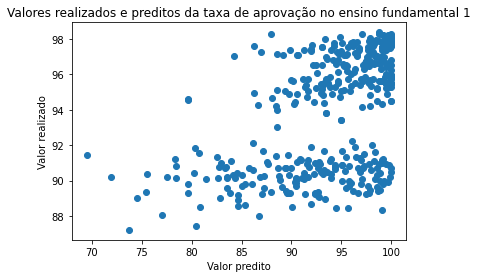

In [172]:
mult_model_1 = sm.OLS(y1, x , missing = 'drop').fit()
y1_pred = mult_model_1.predict(X_val)

y1_realized = df_validation['tx_aprov_ef_1'][X_val.index]

plt.scatter(y1_realized, y1_pred)
plt.title('Valores realizados e preditos da taxa de aprovação no ensino fundamental 1')
plt.xlabel('Valor predito')
plt.ylabel('Valor realizado')
plt.show()

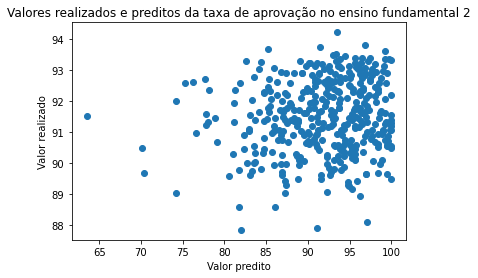

In [173]:
mult_model_2 = sm.OLS(y2, x , missing = 'drop').fit()
y2_pred = mult_model_2.predict(X_val)

y2_realized = df_validation['tx_aprov_ef_2'][X_val.index]

plt.scatter(y2_realized, y2_pred)
plt.title('Valores realizados e preditos da taxa de aprovação no ensino fundamental 2')
plt.xlabel('Valor predito')
plt.ylabel('Valor realizado')
plt.show()

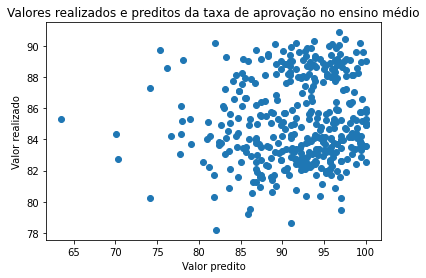

In [174]:
mult_model_3 = sm.OLS(y3, x , missing = 'drop').fit()
y3_pred = mult_model_3.predict(X_val)

y3_realized = df_validation['tx_aprov_ef_2'][X_val.index]

plt.scatter(y3_realized, y3_pred)
plt.title('Valores realizados e preditos da taxa de aprovação no ensino médio')
plt.xlabel('Valor predito')
plt.ylabel('Valor realizado')
plt.show()